In [2]:
# Import necessary libraries

import pandas as pd
import torch
from sklearn.model_selection import train_test_split

In [3]:
# Load data and set up device

data = pd.read_csv('./data/edos-labelled-annotations.csv', nrows=20000)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Extract text and labels, and map labels to numerical values
text = list(data['text'])
labels = data['label_sexist'].map({'sexist': 1, 'not sexist': 0}).values
labels = torch.tensor(labels, dtype=torch.long)

# Split data into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(text, labels, test_size=0.8, random_state=42)
valid_text, test_text, valid_labels, test_labels = train_test_split(temp_text, temp_labels, test_size=0.5, random_state=42)

In [4]:
#Load BERT tokenizer and model
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Move model to the appropriate device (GPU or CPU)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize the data

tokenized_train = tokenizer(train_text, truncation=True, padding=True, return_tensors="pt")
tokenized_valid = tokenizer(valid_text, truncation=True, padding=True, return_tensors="pt")
tokenized_test = tokenizer(test_text, truncation=True, padding=True, return_tensors="pt")

In [6]:
# Define a custom dataset class

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, device):
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],
                                      device=self.device) 
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances for training, validation, and testing

train_data = CustomDataset(tokenized_train, train_labels, device)
valid_data = CustomDataset(tokenized_valid, valid_labels, device)
test_data = CustomDataset(tokenized_test, test_labels, device)

In [7]:
# Create data loaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [8]:
# Train the model

from tqdm import tqdm

epochs = 5
learning_rate = 1e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    num_batches_train = 0

    batch_progress = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs} Training', leave=False)

    for batch in batch_progress:
        inputs = {key: value.to(device) if key != 'labels' else value for key, value in batch.items()}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        num_batches_train += 1
        batch_progress.set_postfix(loss=f'{total_train_loss / num_batches_train:.4f}')

    average_train_loss = total_train_loss / num_batches_train

    total_validation_loss = 0
    num_batches_validation = 0
    model.eval()

    for batch in valid_dataloader:
        with torch.no_grad():
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss

            total_validation_loss += loss.item()
            num_batches_validation += 1

    average_validation_loss = total_validation_loss / num_batches_validation

    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {average_train_loss:.4f}, Val Loss: {average_validation_loss:.4f}')

    scheduler.step()


Epoch 1/5 Training:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_6040/1379483561.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_6040/1379483561.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx],


Epoch 1/5 - Train Loss: 0.5013, Val Loss: 0.4778


Epoch 2/5 - Train Loss: 0.3444, Val Loss: 0.4708


Epoch 3/5 - Train Loss: 0.2049, Val Loss: 0.5324


Epoch 4/5 - Train Loss: 0.1996, Val Loss: 0.6001


Epoch 5/5 - Train Loss: 0.1836, Val Loss: 0.6066


Testing:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_6040/1379483561.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_6040/1379483561.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx],


Test Loss: 0.5993
Accuracy: 0.8401


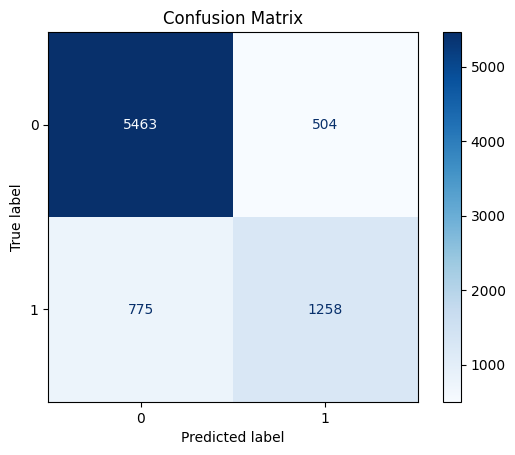

In [9]:
# Test the model and evaluate performance

import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

model.eval()

total_test_loss = 0
num_batches_test = 0

test_progress_bar = tqdm(test_dataloader, desc=f'Testing', leave=False)

for batch in test_progress_bar:
    with torch.no_grad():
        inputs = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        total_test_loss += loss.item()
        num_batches_test += 1

        true_labels.extend(batch['labels'].cpu().numpy())
        predicted_labels.extend(outputs.logits.argmax(dim=1).cpu().numpy())

average_test_loss = total_test_loss / num_batches_test
test_progress_bar.set_postfix({'test_loss': average_test_loss}, refresh=True)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Test Loss: {average_test_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Save the model and tokenizer

save_directory = "./bert-model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./bert-model/tokenizer_config.json',
 './bert-model/special_tokens_map.json',
 './bert-model/vocab.txt',
 './bert-model/added_tokens.json')